In [1]:
import torch
from torch import nn
import torchvision
import torchvision.models as models
import numpy as np
import os
from torchsummary import summary
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import sys
from torch.utils.data import DataLoader

sys.path.append("/workspaces/ood/")


from ood.data import EmbDataset
from ood.model import LinearClass
from ood.train import train
from ood.eval import accuracy
from ood.utils import add_labels, predict_on_whole_dataset


import warnings

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

device = torch.device("cuda")

torch.cuda.is_available()

True

### 1) Load data

In [2]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# transform = transforms.Compose(
#     [
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         normalize,
#     ]
# )
# cifar_data_train = torchvision.datasets.CIFAR10(
#     "../data/cifar10", download=False, transform=transform
# )
# cifar_data_test = torchvision.datasets.CIFAR10(
#     "../data/cifar10", download=False, transform=transform, train=False
# )

# svhn_data_train = torchvision.datasets.SVHN(
#     "../data/svhn", download=False, transform=transform
# )
# svhn_data_test = torchvision.datasets.SVHN(
#     "../data/svhn", download=False, transform=transform, split="test"
# )

### 2) Load model

In [3]:
# from ood.utils import load_byol
# model = load_byol('/workspaces/ood/data/models/pretrain_res50x1.pth.tar', device)

### 3) Predict

In [4]:
# model_name = 'byol'
# predict_on_whole_dataset(model, cifar_data_test, f'{model_name}_cifar_test', device)
# predict_on_whole_dataset(model, cifar_data_train, f'{model_name}_cifar_train', device)
# predict_on_whole_dataset(model, svhn_data_train, f'{model_name}_svhn_train', device)
# predict_on_whole_dataset(model, svhn_data_test, f'{model_name}_svhn_test', device)

### 4) Train linear classification model on soft embeddings of Cifar 10

In [14]:
# from torch.optim.lr_scheduler import StepLR

# model_name = 'byol'

# cifar_train = EmbDataset(f'../data/predictions/{model_name}_cifar_train.npy', emb_size=2048)
# cifar_test = EmbDataset(f'../data/predictions/{model_name}_cifar_test.npy', emb_size=2048)

# cifar_linear_model = LinearClass(emb_size=2048, num_classes=10).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(cifar_linear_model.parameters(), lr=1e-4, weight_decay=1e-5)


# scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# cifar_train_dataloader = DataLoader(cifar_train, batch_size=512, shuffle=True)
# cifar_test_dataloader = DataLoader(cifar_test, batch_size=512, shuffle=False)

# train(cifar_train_dataloader, cifar_test_dataloader,
#     cifar_linear_model, optimizer, scheduler,
#     criterion, accuracy,
#     train_epoch=200, metric_freq=10000, device=device)

In [15]:
# torch.save(cifar_linear_model.state_dict(), f'../data/trained_models/{model_name}_cifar_linear_model0.9040test_accuracy.pth')

### 4) Perform out of distribution detection

In [27]:
from ood.ood_detection import compute_softmax_and_energy

model_name = "byol"
softmax_scores_distr, energy_scores_distr = compute_softmax_and_energy(
    linear_model_path=f"../data/trained_models/{model_name}_cifar_linear_model0.9040test_accuracy.pth",
    emb_size=2048,
    num_classes=10,
    in_distr_test_path=f"../data/predictions/{model_name}_cifar_test.npy",
    out_distr_test_path=f"../data/predictions/{model_name}_svhn_test.npy",
    in_distr_ds_name="cifar",
    out_distr_ds_name="svhn",
    device=device,
)

Linear model in distribution test accuracy: 0.90480
Computing softmax and energy scores...


100%|██████████| 26032/26032 [00:05<00:00, 5017.09it/s]


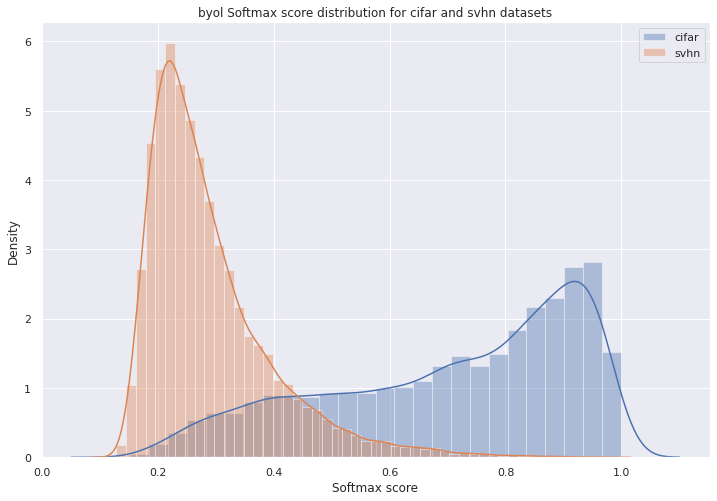

In [26]:
from ood.draw import draw_score_distr_plot

draw_score_distr_plot(
    scores_distr=softmax_scores_distr,
    score_type="Softmax",
    model_name=model_name,
    in_data_name="cifar",
    out_data_name="svhn",
)

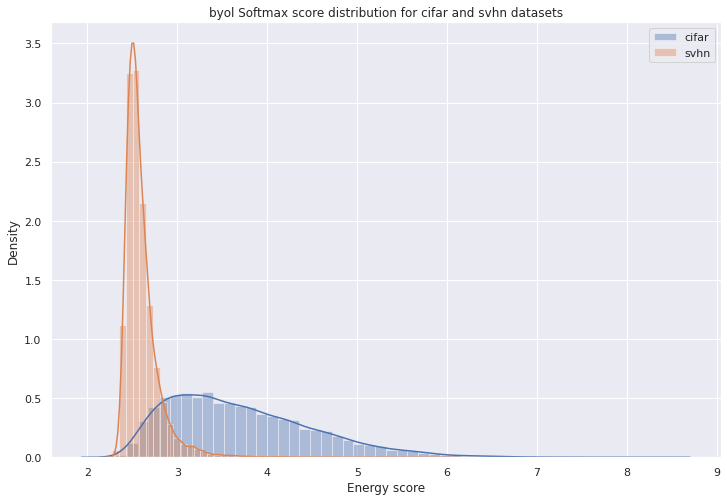

In [28]:
draw_score_distr_plot(
    scores_distr=energy_scores_distr,
    score_type="Energy",
    model_name=model_name,
    in_data_name="cifar",
    out_data_name="svhn",
)

In [29]:
from ood.ood_metrics import get_measures
from ood.utils import prettify_value

auroc, aupr, fpr = get_measures(
    softmax_scores_distr["cifar"], softmax_scores_distr["svhn"]
)
auroc, aupr, fpr = prettify_value((auroc, aupr, fpr), num_round=5, ljust_num=7)

print(f" {model_name} softmax scores: \n auroc {auroc}\n aupr {aupr}\n FPR95 {fpr}")

 byol softmax scores: 
 auroc 0.94404
 aupr 0.90462
 FPR95 0.33443


In [30]:
auroc, aupr, fpr = get_measures(
    energy_scores_distr["cifar"], energy_scores_distr["svhn"]
)
auroc, aupr, fpr = prettify_value((auroc, aupr, fpr), num_round=5, ljust_num=7)

print(f" {model_name} energy scores: \n auroc {auroc}\n aupr {aupr}\n FPR95 {fpr}")

 byol energy scores: 
 auroc 0.95593
 aupr 0.91585
 FPR95 0.23698
